In [1]:
import os
import sys

In [2]:
parent_dir = os.path.dirname(os.getcwd())
sys.path.append(parent_dir)

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv('../data/Insurance_claims_data.csv')

print(df.shape)
df.head()

test_df = df.sample(20000, random_state=23)

# Create train/test split with stratification since data is imbalanced
X = test_df.drop('claim_status', axis=1)
y = test_df['claim_status']

# Use stratify parameter to maintain class distribution in both splits
# Use test_size=0.2 for 80/20 split which is common practice
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y,
    test_size=0.2,
    random_state=42, # For reproducibility
    stratify=y # Maintain class distribution
)

# Print shapes to verify split
print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print("\nClass distribution in splits:")
print("Training set:", pd.Series(y_train).value_counts(normalize=True))
print("Test set:", pd.Series(y_test).value_counts(normalize=True))


(58592, 41)
Training set shape: (16000, 40)
Test set shape: (4000, 40)

Class distribution in splits:
Training set: claim_status
0    0.935063
1    0.064937
Name: proportion, dtype: float64
Test set: claim_status
0    0.935
1    0.065
Name: proportion, dtype: float64


In [4]:
import nest_asyncio
nest_asyncio.apply()

In [5]:
from xgboost import XGBClassifier

from src.modules.fe import CAAFETransformer

model = XGBClassifier(
        seed=42,
        objective="binary:logistic",
        eval_metric="logloss",
        n_jobs=-1,
        use_label_encoder=False,
        verbosity=0,
        enable_categorical=True,
    )

fe = CAAFETransformer(
    llm_model='gpt-4.1-mini',
    target_name="claim_status",
    dataset_description="Insurance claim data.",
    max_features=5,
    iterations=3,
    n_splits=5,
    n_repeats=2,
    random_state=123,
    base_classifier=model,
)

In [6]:
fe.fit(X_train, y_train, show_prompts=True)

[2025-06-02 22:23:41] INFO:src.modules.fe.CAAFETransformer: Starting CAAFETransformer.fit(): running iterative feature engineering.
[2025-06-02 22:23:41] INFO:src.modules.fe.CAAFETransformer: CAAFE transformer initialization completed:
  Target: claim_status
  Dataset shape: (16000, 41)
  Original features: 40
  Max features per iteration: 5
  Max iterations: 3
  Optimization metric: accuracy
  LLM model: gpt-4.1-mini
  CV splits: 5
  CV repeats: 2
[2025-06-02 22:23:41] INFO:src.modules.fe.CAAFETransformer: Starting iterative feature engineering process...
[2025-06-02 22:23:41] INFO:src.modules.fe.CAAFETransformer: 

→ Evaluating baseline performance (no added features)...

[2025-06-02 22:23:49] INFO:src.modules.fe.CAAFETransformer: 
Baseline ROC AUC: 0.539 (±0.021)
[2025-06-02 22:23:49] INFO:src.modules.fe.CAAFETransformer: 
Baseline Accuracy: 0.934 (±0.005)
[2025-06-02 22:23:49] INFO:src.modules.fe.CAAFETransformer: 

--- Iteration 1/3 ---

[2025-06-02 22:24:13] INFO:src.modules.fe.C

CAAFETransformer(base_classifier=XGBClassifier(base_score=None, booster=None,
                                               callbacks=None,
                                               colsample_bylevel=None,
                                               colsample_bynode=None,
                                               colsample_bytree=None,
                                               device=None,
                                               early_stopping_rounds=None,
                                               enable_categorical=True,
                                               eval_metric='logloss',
                                               feature_types=None,
                                               feature_weights=None, gamma=None,
                                               grow_policy=None,
                                               importance_type=None,
                                               interaction_constr...
                                               max_depth=None, max_leaves=None,
                                               min_child_weight=None,
                                               missing=nan,
                                               monotone_constraints=None,
                                               multi_strategy=None,
                                               n_estimators=None, n_jobs=-1,
                                               num_parallel_tree=None, ...),
                 dataset_description='Insurance claim data.', iterations=3,
                 llm_model='gpt-4.1-mini',
                 logger=<Logger src.modules.fe.CAAFETransformer (INFO)>,
                 max_features=5, n_splits=5, random_state=123,
                 target_name='claim_status')

In [8]:
fe.save_code("features.py")

[2025-06-02 22:29:02] INFO:src.modules.fe.CAAFETransformer: Feature-generation code saved to features.py


In [9]:
fe.usages

[Usage(requests=2, request_tokens=9502, response_tokens=1124, total_tokens=10626, details={'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0, 'cached_tokens': 3712}),
 Usage(requests=8, request_tokens=51405, response_tokens=1168, total_tokens=52573, details={'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0, 'cached_tokens': 44672}),
 Usage(requests=3, request_tokens=16621, response_tokens=841, total_tokens=17462, details={'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0, 'cached_tokens': 11520})]

In [10]:
print(fe.get_formatted_agent_notepad(n=-1))

Iteration 1
Features created: max_torque_nm, max_power_bhp, vehicle_age_subscription_length_interaction, safety_equipment_count, length_to_width_ratio, customer_age_group
Features dropped: policy_id
Performance before adding features ROC 0.5392, ACC 0.9338.
Performance after adding features ROC 0.5794, ACC 0.9328.
Improvement ROC +0.04021, ACC -0.0009687.
Note: Code was ACCEPTED and applied to the dataset. Columns were successfully added/dropped.

Iteration 2
Features created: subscription_to_vehicle_age_ratio, torque_to_displacement_ratio, power_to_displacement_ratio, customer_age_fine_group, log_region_density, has_advanced_safety_features
Features dropped: max_power_bhp, length_to_width_ratio
Performance before adding features ROC 0.5794, ACC 0.9328.
Performance after adding features ROC 0.58, ACC 0.9326.
Improvement ROC +0.0006632, ACC -0.0002813.
Note: Code was ACCEPTED and applied to the dataset. Columns were successfully added/dropped.

Iteration 3
Features created: age_gap, eng

In [11]:
X_transformed = fe.transform(X_train)
print(X_transformed.shape)
X_transformed.head()

(16000, 49)


,subscription_length,vehicle_age,customer_age,region_code,region_density,segment,model,fuel_type,max_torque,max_power,...,max_torque_nm,customer_age_group,subscription_to_vehicle_age_ratio,log_region_density,has_advanced_safety_features,age_gap,engine_power_density,safety_airbags_interaction,subscription_length_bucket,freq_segment
7047,0.5,0.0,47,C7,6112,A,M1,CNG,60Nm@3500rpm,40.36bhp@6000rpm,...,60.0,40-49,0.500000,8.718173,0,47.0,0.075377,6,Short,0.295938
25110,0.9,2.4,38,C2,27003,B2,M6,Petrol,113Nm@4400rpm,88.50bhp@6000rpm,...,113.0,30-39,0.264706,10.203740,1,35.6,0.094403,22,Short,0.313625
58586,1.5,3.2,39,C9,17804,A,M3,Petrol,91Nm@4250rpm,67.06bhp@5500rpm,...,91.0,30-39,0.357143,9.787235,1,35.8,0.091091,14,Short,0.295938
56582,0.8,2.6,49,C9,17804,C2,M4,Diesel,250Nm@2750rpm,113.45bhp@4000rpm,...,250.0,40-49,0.222222,9.787235,1,46.4,0.167448,96,Short,0.238375
5304,4.3,0.8,58,C14,7788,A,M1,CNG,60Nm@3500rpm,40.36bhp@6000rpm,...,60.0,50-59,2.388889,8.960468,0,57.2,0.075377,6,Medium,0.295938


In [12]:

from sklearn.preprocessing import OrdinalEncoder


categorical_cols = [
    col
    for col in X_transformed.columns
    if (
        X_transformed[col].dtype == "object"
        or pd.api.types.is_categorical_dtype(X_transformed[col])
    )
    and col != 'claim_status'
]

# Prepare encoder
encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)

# Fit only on train set
df_train_cats = X_transformed[categorical_cols].astype(str)
encoder.fit(df_train_cats)

OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

In [13]:
X_transformed[categorical_cols] = encoder.transform(df_train_cats)

X_transformed["claim_status"] = y_train

In [14]:
from src.modules.xgb_tune import XGBoostTuner


llm_tuner = XGBoostTuner(X_transformed, 'claim_status')

In [15]:
import nest_asyncio
nest_asyncio.apply()

llm_tuner.tune()

Metric Explanation: The target variable 'claim_status' is highly imbalanced (only ~6.5% positive class). You are primarily interested in PPV (Positive Predictive Value), also known as precision. For model selection, the most appropriate built-in scikit-learn metric is 'precision', which directly optimizes for the quantity you care about. This ensures that hyperparameter tuning selects configurations yielding the highest likelihood that predicted positives are indeed true positives, crucial in imbalanced/binary insurance claim contexts.
Metric: precision
Initial Search Space: Given this insurance claims dataset, there are several key considerations for hyperparameter search space setup:

1. **Class Imbalance:** The target ('claim_status') has a pronounced imbalance (~6.5% positive). This justifies a wide, careful exploration of 'scale_pos_weight'. The optimal value is typically set to (# negative / # positive) or a range around it.
   - Here: 14961 / 1039 ≈ 14.4
   - We'll use logunifor

In [16]:
# Get just the best configuration
best_config = llm_tuner.get_best_config()
print("Best hyperparameters:", best_config)

# Get comprehensive summary
summary = llm_tuner.get_tuning_summary()
print(f"Best score: {summary['best_score']}")
print(f"Best config: {summary['best_config']}")
print(f"Completed {summary['total_iterations']} iterations")
print(f"Score improvement: {summary['improvement_over_baseline']}")

Best hyperparameters: {'colsample_bylevel': np.float64(0.6819796804585989), 'colsample_bytree': np.float64(0.8769995435403075), 'gamma': np.float64(0.36267123343479407), 'learning_rate': np.float64(0.011181214516269689), 'max_depth': 9, 'min_child_weight': np.float64(0.16983181528269106), 'n_estimators': 216, 'reg_alpha': np.float64(1.390273909440899), 'reg_lambda': np.float64(0.6519317236818201), 'scale_pos_weight': np.float64(8.758423316352669), 'subsample': np.float64(0.7861149134412877)}
Best score: 0.6
Best config: {'colsample_bylevel': np.float64(0.6819796804585989), 'colsample_bytree': np.float64(0.8769995435403075), 'gamma': np.float64(0.36267123343479407), 'learning_rate': np.float64(0.011181214516269689), 'max_depth': 9, 'min_child_weight': np.float64(0.16983181528269106), 'n_estimators': 216, 'reg_alpha': np.float64(1.390273909440899), 'reg_lambda': np.float64(0.6519317236818201), 'scale_pos_weight': np.float64(8.758423316352669), 'subsample': np.float64(0.7861149134412877)}

In [17]:
x_df = X_transformed.drop('claim_status', axis=1)
y_df = X_transformed['claim_status']

In [18]:
if best_config:
    final_model = XGBClassifier(**best_config)
    final_model.fit(x_df, y_df)

In [21]:
X_test_transformed = fe.transform(X_test)
X_test_transformed[categorical_cols] = encoder.transform(X_test_transformed[categorical_cols])

y_pred = final_model.predict(X_test_transformed)
y_pred_proba = final_model.predict_proba(X_test_transformed)[:, 1]

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import (
    precision_score,
    recall_score,
    accuracy_score,
    roc_auc_score,
    f1_score,
    matthews_corrcoef
)


def metrics_display(y_test, y_pred, y_pred_proba):
    
    # Obtain confusion matrix
    cm = confusion_matrix(y_test, y_pred)
   
    # Output classification metrics
    tn, fp, fn, tp = cm.ravel()
   
    print(f'ROC_AUC score: {roc_auc_score(y_test, y_pred_proba):.3f}')
    print(f'f1 score: {f1_score(y_test, y_pred):.3f}')
    print(f'Accuracy: {accuracy_score(y_test, y_pred)*100:.2f}%')
    print(f'Precision: {precision_score(y_test, y_pred)*100:.2f}%')
    print(f'Detection rate: {recall_score(y_test, y_pred)*100:.2f}%')
    print(f'False alarm rate: {fp / (tn+fp)*100}%')
    print(f'MCC: {matthews_corrcoef(y_test, y_pred):.2f}')
   
    # Display confusion matrix
    # ConfusionMatrixDisplay.from_predictions(y_test, y_pred, values_format='.5g', colorbar=False)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()

ROC_AUC score: 0.621
f1 score: 0.096
Accuracy: 88.25%
Precision: 9.62%
Detection rate: 9.62%
False alarm rate: 6.283422459893048%
MCC: 0.03


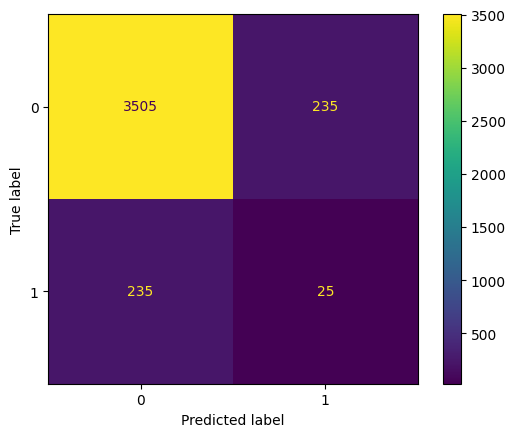

In [24]:
metrics_display(y_test, y_pred, y_pred_proba)